# Time-series prediction (temperature from weather stations)

This notebook illustrates:

* Predicting the "next" value of a long time-series
* Using a LSTM model on numeric data
* Serving a LSTM model

<b>Note:</b>
See [(Time series prediction with RNNs and TensorFlow)](../05_artandscience/d_customestimator.ipynb) for a very similar example, except that it works with multiple short sequences.

In [1]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%datalab project set -p $PROJECT

# Data exploration and cleanup

The data are temperature data from US weather stations. This is a public dataset from NOAA.

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as bq
from __future__ import print_function

In [5]:
query="""
SELECT
  stationid, date,
  MAX(tmin) AS tmin,
  MAX(tmax) AS tmax,
  IF (MOD(ABS(FARM_FINGERPRINT(stationid)), 10) < 7, True, False) AS is_train
FROM (
  SELECT
    wx.id as stationid,
    wx.date as date,
    CONCAT(wx.id, " ", CAST(wx.date AS STRING)) AS recordid,
    IF (wx.element = 'TMIN', wx.value/10, NULL) AS tmin,
    IF (wx.element = 'TMAX', wx.value/10, NULL) AS tmax
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_2016` AS wx
  WHERE STARTS_WITH(id, 'USW000')
)
GROUP BY
  stationid, date
ORDER BY
  stationid, date
"""
df = bq.Query(query).execute().result().to_dataframe()
df.head()

,stationid,date,tmin,tmax,is_train
0,USW00003013,2016-01-01,-16.0,3.9,False
1,USW00003013,2016-01-02,-14.9,11.1,False
2,USW00003013,2016-01-03,-9.9,10.6,False
3,USW00003013,2016-01-04,-11.6,13.9,False
4,USW00003013,2016-01-05,-6.0,12.8,False


In [6]:
df.describe()

,tmin,tmax
count,408241.000000,408271.000000
mean,7.679339,19.674030
std,10.608869,11.435323
min,-57.700000,-35.500000
25%,0.400000,12.200000
50%,8.300000,21.700000
75%,15.800000,28.900000
max,37.600000,51.700000


Unfortunately, there are missing observations on some days.

In [7]:
df.isnull().sum()

stationid        0
date             0
tmin         11316
tmax         11286
is_train         0
dtype: int64

One way to fix this is to do a pivot table and then replace the nulls by filling it with nearest valid neighbor

In [8]:
def cleanup_nulls(df, variablename):
  df2 = df.pivot_table(variablename, 'date', 'stationid', fill_value=np.nan)
  print('Before: {} null values'.format(df2.isnull().sum().sum()))
  df2.fillna(method='ffill', inplace=True)
  df2.fillna(method='bfill', inplace=True)
  df2.dropna(axis=1, inplace=True)
  print('After: {} null values'.format(df2.isnull().sum().sum()))
  return df2

In [9]:
traindf = cleanup_nulls(df[df['is_train']], 'tmin')

Before: 14986 null values
After: 0 null values


In [10]:
traindf.head()

stationid,USW00003016,USW00003017,USW00003024,USW00003026,USW00003028,USW00003029,USW00003030,USW00003031,USW00003032,USW00003048,...,USW00094990,USW00094991,USW00094992,USW00094993,USW00094994,USW00094995,USW00094996,USW00096404,USW00096407,USW00096408
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,-22.1,-14.3,-6.6,-14.3,-14.9,-12.7,-9.9,-1.0,4.4,-3.2,...,-7.7,-9.3,-8.2,-8.2,-7.1,-8.9,-9.3,-17.4,-3.0,-7.0
2016-01-02,-21.0,-8.8,-4.9,-12.7,-10.5,-13.8,-8.2,0.6,3.9,-7.8,...,-6.6,-9.9,-4.9,-8.2,-10.5,-10.2,-7.9,-19.5,-3.0,-7.0
2016-01-03,-17.1,-9.3,-3.8,-10.5,-8.8,-13.2,-5.5,-1.0,2.2,-10.0,...,-11.0,-7.1,-7.1,-13.2,-10.5,-9.5,-9.5,-16.0,-3.0,-7.0
2016-01-04,-14.3,-7.7,-5.5,-8.2,-9.3,-7.1,-9.3,-2.1,1.1,-7.9,...,-8.8,-7.1,-9.9,-16.6,-13.2,-8.6,-9.5,-24.0,-3.2,-7.0
2016-01-05,-11.0,-4.9,-2.1,-7.1,-6.6,-2.7,-3.2,1.1,5.6,-1.1,...,-6.0,-7.7,-2.1,-6.6,-16.0,-7.5,-6.3,-28.0,-3.2,-7.0


366 values in the sequence


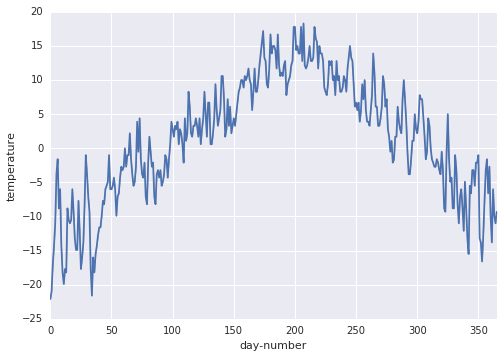

In [11]:
seq = traindf.iloc[:,0]
print('{} values in the sequence'.format(len(seq)))
ax = sns.tsplot(seq)
ax.set(xlabel='day-number', ylabel='temperature');

In [12]:
seq.to_string(index=False).replace('\n', ',')

u'date,-22.1,-21.0,-17.1,-14.3,-11.0,-3.8,-1.6,-8.8,-6.0,-14.3,-18.2,-19.9,-17.7,-18.2,-8.8,-10.5,-11.0,-10.5,-6.0,-9.3,-13.2,-14.9,-14.9,-7.7,-12.1,-17.7,-16.0,-13.8,-8.2,-1.0,-3.8,-7.1,-9.3,-17.7,-21.6,-16.0,-18.2,-15.5,-14.3,-12.7,-11.6,-11.6,-9.9,-7.7,-8.2,-6.0,-5.5,-4.9,-1.0,-6.0,-6.0,-5.5,-4.3,-6.0,-9.9,-7.1,-6.6,-4.3,-2.7,-3.2,-2.7, 0.0,-2.7,-1.0,-1.0, 2.2,-1.6,-3.8,-5.5,-4.9,-2.7, 3.9,-0.5, 4.4,-1.6,-3.8,-4.3,-2.1,-7.1,-8.2,-2.1, 1.7,-0.5,-2.7,-2.1,-7.1,-8.2,-3.8,-3.2,-4.3,-3.2,-5.5,-4.9,-3.8,-1.0,-1.6,-4.3,-1.6, 0.6, 3.9, 2.8, 1.7, 3.3, 2.8, 3.9, 0.6, 2.8, 2.2, 0.6,-2.1, 4.4, 1.1, 2.2, 8.3, 6.1, 2.2, 1.7, 3.3, 3.3, 4.4, 3.3, 1.7, 4.4, 0.6, 2.8, 4.4, 8.3, 5.0, 1.7, 6.7, 6.7, 0.6, 0.6, 2.2, 4.4, 9.4, 5.6, 3.3, 4.4, 5.6,10.6,10.6, 7.2, 1.7, 2.8, 7.2, 3.3, 6.1, 2.2, 3.3, 4.4, 3.3, 5.0, 6.7, 8.3, 8.9,10.0,10.0, 8.9,10.6,10.0,10.6,11.7,10.0, 9.4, 5.6, 8.3,11.7, 8.3, 8.3,10.0,12.2,13.9,15.6,17.2,13.3,12.8, 9.4, 8.9,11.7,16.7,13.9,15.0,15.0,14.4,11.7,16.7,12.2,10.6,11.1,10.6,12.2,12.8

In [13]:
# Save the data to disk in such a way that each time series is on a single line
def to_csv(indf, filename):
  df = cleanup_nulls(indf, 'tmin')
  print('Writing {} sequences to {}'.format(len(df.columns), filename))
  with open(filename, 'w') as ofp:
    for i in xrange(0, len(df.columns)):
      if i%10 == 0:
        print('{}'.format(i), end='...')
      seq = traindf.iloc[:,i]
      line = seq.to_string(index=False, header=False).replace('\n', ',')
      ofp.write(line + '\n')
    print('Done')
to_csv(df[df['is_train']], 'train.csv')
to_csv(df[~df['is_train']], 'eval.csv')

Before: 14986 null values
After: 0 null values
Writing 797 sequences to train.csv
0...10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...360...370...380...390...400...410...420...430...440...450...460...470...480...490...500...510...520...530...540...550...560...570...580...590...600...610...620...630...640...650...660...670...680...690...700...710...720...730...740...750...760...770...780...790...Done
Before: 6457 null values
After: 0 null values
Writing 353 sequences to eval.csv
0...10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...Done


In [14]:
%bash
ls -l *.csv
head -1 eval.csv | tr ',' ' ' | wc
wc *.csv

-rw-r--r-- 1 root root  650585 Nov 25 05:51 eval.csv
-rw-r--r-- 1 root root 1473277 Nov 25 05:51 train.csv
      1     366    1869
    353   36319  650585 eval.csv
    797   90815 1473277 train.csv
   1150  127134 2123862 total


Our CSV file sequences consist of 366 numbers. For training, each instance's 0~364 numbers are inputs, and 1~365 are truth. However, we will set up the placeholder input for the model to have a variable number of inputs, so that given 0~(N-1) inputs, the model will predict the Nth value. Consequently, we'll train it that way as well.

# Model


We will use TensorFlow's [Estimator](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Estimator) to build our model. Estimators help construct the training/evaluation/prediction graph. They reuse the common graph, and fork only when needed (i.e. input_fn). They also handle model export. Models exported can be deployed to Google Cloud ML Engine for online prediction.

In [15]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
import tensorflow.contrib.rnn as rnn

# tf.decode_csv requires DEFAULTS to infer data types and default values.
SEQ_LEN = 366
DEFAULTS = [[0.0] for x in xrange(0, SEQ_LEN)]

# The Estimator API requires named features.
TIMESERIES_FEATURE_NAME = 'rawdata'

# Training batch size.
BATCH_SIZE = 25

## Input

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.

In [16]:
def create_input_fn(filename, mode):  
  """Creates an input_fn for estimator in training or evaluation."""
  
  def _input_fn():
    """Returns named features and labels, as required by Estimator."""    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=None, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    # parse the csv values
    batch_data = tf.decode_csv(value, record_defaults=DEFAULTS)
    batch_data = tf.transpose(batch_data) # [BATCH_SIZE, SEQ_LEN]

    # Get x and y. They are both of shape [BATCH_SIZE, SEQ_LEN - 1]
    batch_len = tf.shape(batch_data)[0]
    x = tf.slice(batch_data, [0, 0], [batch_len, SEQ_LEN-1])
    y = tf.slice(batch_data, [0, 1], [batch_len, SEQ_LEN-1])
    
    return {TIMESERIES_FEATURE_NAME: x}, y   # dict of features, target

  return _input_fn

## Inference Graph

Following Estimator's requirements, we will create a model_fn representing the inference model. Note that this function defines the graph that will be used in training, evaluation and prediction.

To supply a model function to the Estimator API, you need to return a ModelFnOps. The rest of the function creates the necessary objects.

In [17]:
#  Think of the size of each LSTM unit as the number of features that you want it to extract
#  and the number of LSTM units as the complexity with which these features are combined.
LSTM_SIZE = [10, 20]
DNN_SIZE  = [50, 25]
  
# scale the temperatures to make the optimization easier; tmin values are -58 to 38, scale it to be 0 to 1
def scale_temperature(t):
  return (t + 58) / (38+58)

def unscale_temperature(sc):
  return (sc*(38+58)) - 58

def model_fn(features, targets, mode):
  """Define the inference model."""
  
  # scale the input values to lie between 0-1. this will help optimization
  input_seq = scale_temperature(features[TIMESERIES_FEATURE_NAME])
  
  #lat = features['latitude']

  # RNN requires input tensor rank > 2. Adding one dimension.
  input_seq = tf.expand_dims(input_seq, axis=-1)
  
  # LSTM output will be [BATCH_SIZE, SEQ_LEN - 1, lstm_output_size]
  lstm_layer = [tf.nn.rnn_cell.LSTMCell(size) for size in LSTM_SIZE]
  lstm_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_layer)
  lstm_outputs, _ = tf.nn.dynamic_rnn(cell=lstm_cell,
                                      inputs=input_seq,
                                      dtype=tf.float32)
  
  # Reshape to [BATCH_SIZE * (SEQ_LEN - 1), lstm_output] so it is 2-D and can
  # be fed to next layer.
  lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])
  
  #extras = [lstm_outputs, lat, lon]
  
  # Add hidden layers on top of LSTM layer to add some "nonlinear" to the model.
  prev_layer = [lstm_outputs]
  for h in DNN_SIZE:
    hidden1 = tf.contrib.layers.fully_connected(inputs=prev_layer[-1], num_outputs=h)
    prev_layer.append(hidden1)
    
  uniform_initializer = tf.random_uniform_initializer(minval=-0.08, maxval=0.08)
  predictions = tf.contrib.layers.fully_connected(inputs=prev_layer[-1],
                                                  num_outputs=1,
                                                  activation_fn=None,
                                                  weights_initializer=uniform_initializer,
                                                  biases_initializer=uniform_initializer)

  # predictions are all we need when mode is not train/eval.
  # but remember to unscale the values
  predictions_dict = {"predicted_temperature": unscale_temperature(predictions)}

  # If train/evaluation, we'll need to compute loss.
  # If train, we will also need to create an optimizer.
  loss, train_op, eval_metric_ops = None, None, None
  if mode == tf.contrib.learn.ModeKeys.TRAIN or mode == tf.contrib.learn.ModeKeys.EVAL:
    # scale the temperature so that we match the 0-1 scale of predictions
    # it's better to do this rather than unscale the predictions because the
    # learning rate and optimizers are all set up for small numbers
    targets = scale_temperature(targets)
      
    # Note: The reshape below is needed because Estimator needs to know
    # loss shape. Without reshaping below, loss's shape would be unknown.
    targets = tf.reshape(targets, [tf.size(targets)])
    predictions = tf.reshape(predictions, [tf.size(predictions)])
    loss = tf.losses.mean_squared_error(targets, predictions)
    eval_metric_ops = {
      "rmse_scaled": tf.metrics.root_mean_squared_error(targets, predictions)
    }

    if mode == tf.contrib.learn.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(
          loss=loss,
          global_step=tf.contrib.framework.get_global_step(),
          learning_rate=0.01,
          optimizer="Adagrad")
  
  # return ModelFnOps as Estimator requires.
  return tflearn.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

## Training

Distributed training is launched off using an Experiment.  The key line here is that we use tflearn.Estimator rather than, say tflearn.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time using gcloud or Cloud ML Online Prediction.

In [ ]:
def get_train():
  return create_input_fn('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)


def get_eval():
  return create_input_fn('eval.csv', mode=tf.contrib.learn.ModeKeys.EVAL)


def serving_input_fn():
  feature_placeholders = {
      TIMESERIES_FEATURE_NAME: tf.placeholder(tf.float32, [None, None])
  }
  return tflearn.utils.input_fn_utils.InputFnOps(
      feature_placeholders,
      None,
      feature_placeholders
  )


def experiment_fn(output_dir):
    """An experiment_fn required for Estimator API to run training."""

    estimator = tflearn.Estimator(model_fn=model_fn,
                                  model_dir=output_dir,
                                  config=tf.contrib.learn.RunConfig(save_checkpoints_steps=500))
    return tflearn.Experiment(
        estimator,
        train_input_fn=get_train(),
        eval_input_fn=get_eval(),
        export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
            exports_to_keep=1
        )],
        train_steps=1000
    )


shutil.rmtree('training', ignore_errors=True) # start fresh each time.
learn_runner.run(experiment_fn, 'training')

## Model Summary

We can plot model's training summary events using Datalab's ML library.

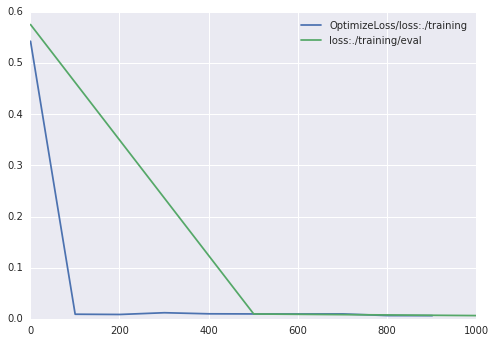

In [19]:
from google.datalab.ml import Summary

summary = Summary('./training')
summary.plot(['OptimizeLoss/loss', 'loss'])

# Prediction

Let's pull up a curve and see how we do at predicting the last few values of the series. A week's forecast is reasonable.

285 inputs; expecting 7 outputs


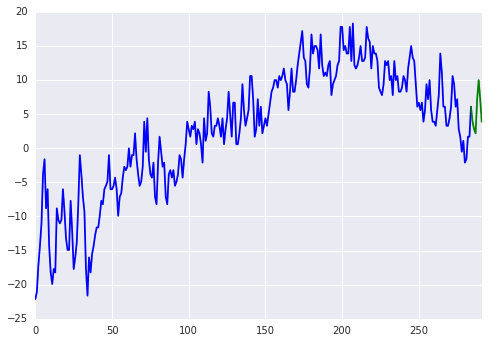

In [20]:
def get_one_series(filename, dayno):
  with open(filename) as fp:
    fields = fp.readline().strip().split(',')
    prediction_data = map(float, fields)
  
    # Upto dayno as input; upto dayno+7 as prediction
    prediction_x = list(prediction_data[:dayno])
    prediction_y = list(prediction_data[dayno:(dayno+7)])

    sns.tsplot(prediction_x, color='blue')
    y_truth_curve = [np.nan] * (len(prediction_x)-1) + [prediction_x[-1]] + prediction_y
    sns.tsplot(y_truth_curve, color='green')
    return prediction_x, prediction_y, y_truth_curve

prediction_x, prediction_y, y_truth_curve = get_one_series('eval.csv', 285)
print('{} inputs; expecting {} outputs'.format(len(prediction_x), len(prediction_y)))

First prediction we will do is just sending x, and for each value in x it will return a predicted value which is for the very next time step. And then we can compare the predicted values with the truth (x+1).

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1859006ed0>, '_model_dir': 'training', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000


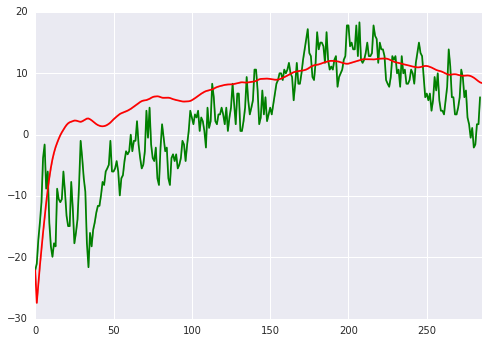

In [21]:
# Load model.
estimator = tflearn.Estimator(model_fn=model_fn, model_dir='training')

# Feed Prediction data.
predict_input_fn = lambda: {TIMESERIES_FEATURE_NAME: tf.constant([prediction_x])}

predicted = list(estimator.predict(input_fn=predict_input_fn))
predicted = [p['predicted_temperature'] for p in predicted]

# Plot prediction source.
sns.tsplot(prediction_x, color='green')

# Plot predicted values.
sns.tsplot([prediction_x[0]] + predicted, color='red');

This time, let's send in x, and predict next n values.
The way we do this is to invoke the prediction on x, take the prediction, append it to x and make another prediction.
Repeat n times and we've created n predictions.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f186e908e90>, '_model_dir': 'training', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000
INFO:tensorflow:Restoring parameters from training/model.ckpt-1000
INFO:tensorflow:Restorin

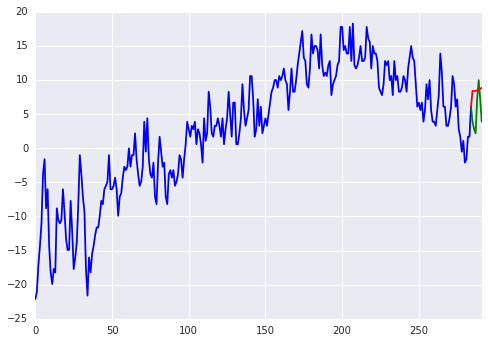

In [22]:
estimator = tflearn.Estimator(model_fn=model_fn, model_dir='training')

# Prediction data starts with x.
x_total = list(prediction_x)

# Make n predictions.
for i in range(len(prediction_y)):
  predict_input_fn = lambda: {TIMESERIES_FEATURE_NAME: tf.constant([x_total])}
  p = list(estimator.predict(input_fn=predict_input_fn))
  # For each step, append the tail element of last predicted values.  
  x_total.append(p[-1]['predicted_temperature'])

# The first len(prediction_x) elements are prediction source. So remove them.
y_predicted = x_total[len(prediction_x):]

# Zero out prediction source (making them nan), add the last value of prediction source
# so the first edge in the curve is plotted, and add predicted values.
y_predicted_curve = [np.nan] * (len(prediction_x)-1) + [prediction_x[-1]] + y_predicted

# Plot prediction source.
sns.tsplot(prediction_x, color='blue')

# Plot truth curve.
sns.tsplot(y_truth_curve, color='green')

# Plot predicted curve.
sns.tsplot(y_predicted_curve, color='red')